Business case and value

The data in the dataset is from a real Czech bank from 1999. The data is about clients and their accounts and has relations account, client, disposiiton, permanent order, transaction, loan, credit card and demographic data. The Relation 'loan' and 'credit card' describe some services which bank offers to its clients. More credit cards can be issued to an account but atmost one loan can be granted for an account.

The business objective is to analyze the transactional behavior of the customers and predict the loan risk status for the same customers.This is useful in cases where credit card companies provide pre-approved loans for customers based on their payment and other factors. Therefore, we can predict customers who pay regulary and who do not.

To acheive this, the below mentioned steps are followed:

Data Preparation

Regression

Clustering



Data Narration

trans.csv - Transaction details of the client

trans_id - record identifier

account_id - account the transaction deals with

date - date of transaction: in the form YYMMDD

type +/- transaction: "PRIJEM" stands for credit "VYDAJ" stands for withdrawal

operation - mode of transaction: "VYBER KARTOU" credit card 
withdrawal "VKLAD" credit in cash "PREVOD Z UCTU" collection from another bank "VYBER" withdrawal in cash "PREVOD NA UCET" remittance to another bank

amount - amount of money

balance - balance after transaction

k_symbol - characterization of the transaction: "POJISTNE" 

insurance payment "SLUZBY" payment for statement "UROK"
 interest credited "SANKC. UROK" sanction interest if negative balance "SIPO" household "DUCHOD" old-age pension "UVER" loan payment

bank - bank of the partner: each bank has unique two-letter code

account - account of the partner


loan.csv - Loan details

loan_id - record identifier

account_id - identification of the account

date - date when the loan was granted: in the form YYMMDD

amount - amount of money

duration - duration of the loan

payments - monthly payments

status - status of paying off the loan: 

    'A' stands for contract finished, no problems, 

    'B' stands for contract finished, loan not payed, 

    'C' stands for running contract, OK so far,
    
    'D' stands for running contract, client in debt




In [130]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pydotplus
import collections
import seaborn as sns
from sklearn import tree
from sklearn.metrics import accuracy_score
from IPython.display import Image


#from google.colab import files
#uploaded = files.upload()



In [131]:
trans_d = pd.read_csv("trans.csv")
loan_d = pd.read_csv("loan_csv.csv")
#account_d = pd.read_csv("account_csv.csv")
#client_d = pd.read_csv("client.csv")
#disp_d = pd.read_csv("disp.csv")
#loan_d.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
'''_column_date = []
_column_frequency = []
_column_district = []
_column_clientdob =[]
for c in loan_d['account_id']:
    _result = account_d.loc[account_d['account_id'] == c]
    _column_date.append(_result['date'].iloc[0])
    _column_frequency.append(_result['frequency'].iloc[0])
    _column_district.append(_result['district_id'].iloc[0])
    _result = disp_d.loc[disp_d['account_id'] == c]
    _result = client_d.loc[client_d['client_id'] == _result['client_id'].iloc[0]]
    _column_clientdob.append(_result['birth_number'].iloc[0])
    #print(_result)'''

"_column_date = []\n_column_frequency = []\n_column_district = []\n_column_clientdob =[]\nfor c in loan_d['account_id']:\n    _result = account_d.loc[account_d['account_id'] == c]\n    _column_date.append(_result['date'].iloc[0])\n    _column_frequency.append(_result['frequency'].iloc[0])\n    _column_district.append(_result['district_id'].iloc[0])\n    _result = disp_d.loc[disp_d['account_id'] == c]\n    _result = client_d.loc[client_d['client_id'] == _result['client_id'].iloc[0]]\n    _column_clientdob.append(_result['birth_number'].iloc[0])\n    #print(_result)"

In [132]:
'''loan_d['account_date'] = _column_date
loan_d['account_loginfrequency'] = _column_frequency
loan_d['account_district'] = _column_district
loan_d['client_birthNumber'] = _column_clientdob'''
loan_d.head()

,loan_id,account_id,date,amount,duration,payments,status
0,5314,1787,930705,96396,12,8033.0,B
1,5316,1801,930711,165960,36,4610.0,A
2,6863,9188,930728,127080,60,2118.0,A
3,5325,1843,930803,105804,36,2939.0,A
4,7240,11013,930906,274740,60,4579.0,A


In [133]:
missing = loan_d.isna().sum()
print(missing)

_statusUnique = list(loan_d['status'].unique())
#_freqUnique = list(loan_d['account_loginfrequency'].unique())
print('Unique values in status :{}'.format(_statusUnique))
#print('Unique values in account login frequency :{}'.format(_freqUnique))

loan_id       0
account_id    0
date          0
amount        0
duration      0
payments      0
status        0
dtype: int64
Unique values in status :['B', 'A', 'C', 'D']


In [134]:
_dict_status = {'A' : 1 , 'B' : 2 ,'C' : 3 ,'D' : 4}
for x in _dict_status.values():
  print(x)
List_values = []
for item in loan_d['status']:
  st = _dict_status.get(item)
  List_values.append(st)
  #print(loan_d['status'])
  #print("{} is {}".format(item ,st))
  


1
2
3
4


In [135]:
loan_d['status'] = List_values

In [136]:
loan_d.head()

,loan_id,account_id,date,amount,duration,payments,status
0,5314,1787,930705,96396,12,8033.0,2
1,5316,1801,930711,165960,36,4610.0,1
2,6863,9188,930728,127080,60,2118.0,1
3,5325,1843,930803,105804,36,2939.0,1
4,7240,11013,930906,274740,60,4579.0,1


**Linear Regression**

With Linear Regression, Predicting the laon amount based on the loan duration and monthly paymenta.Loan amount is dependent variable.Loan duration and monthly payments are dependent variables.


In [137]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

loan_lin = loan_d
#loan_lin.head()

cols = list(loan_lin.columns)
cols.remove('loan_id')
cols.remove('account_id')
cols.remove('amount')
cols.remove('status')
cols.remove('date')
loan_lin.head()

X = loan_lin[cols].iloc[ :, 0:].values
Y = loan_lin['amount']
Y



0       96396
1      165960
2      127080
3      105804
4      274740
        ...  
677    352704
678     52512
679    139488
680     55632
681    240900
Name: amount, Length: 682, dtype: int64

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 1/3, random_state = 0)
X_test

In [51]:
np.savetxt("testdata.csv", X_test, delimiter=",")

In [52]:
np.savetxt("traineddata.csv", X_train, delimiter=",")

In [ ]:

regr = LinearRegression(normalize=True)
regr.fit(X_train, Y_train)
Y_pred = regr.predict(X_test)
Y_pred

In [142]:
regr.coef_

array([4339.30225018,   34.9447877 ])

In [140]:
regr.intercept_

-153348.16619056734

In [141]:
regr.predict([[36, 7685]])

array([271417.40830571])

For 36 years and monthly installments 7685  in test data ,which predicts the  loan amount as 271417 .

After looking at the dataset ,We can say that it is predicting closer since test data mothly installment is little higher.


**Loan_Amount**    **Duration**   **MonthlyPayments**

  258444       -         36     -         7179

  269964       -         36      -        7499

  276084       -         36       -       7669


In [143]:
from sklearn import metrics

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print('Mean squared error: %.2f'% metrics.mean_squared_error(Y_test, Y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination(R2_score): %.2f'% metrics.r2_score(Y_test, Y_pred))


Coefficients: 
 [4339.30225018   34.9447877 ]
Mean squared error: 1815629994.50
Coefficient of determination(R2_score): 0.88


Text(0, 0.5, 'Predictions')

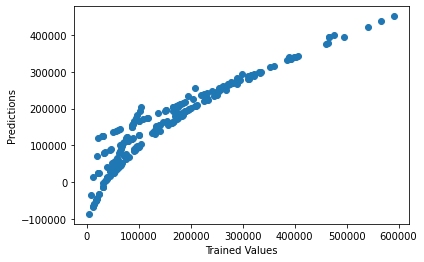

In [59]:
plt.scatter(Y_test, Y_pred)
plt.xlabel('Trained Values')
plt.ylabel('Predictions')

In [ ]:
Apply GMM with PCA

SyntaxError: ignored

In [ ]:
cols = list(loan_d.columns)
cols.remove("loan_id")
X = loan_d[cols].iloc[ :, 1:].values
X

array([[9.30705e+05, 9.63960e+04, 1.20000e+01, 8.03300e+03, 2.00000e+00],
       [9.30711e+05, 1.65960e+05, 3.60000e+01, 4.61000e+03, 1.00000e+00],
       [9.30728e+05, 1.27080e+05, 6.00000e+01, 2.11800e+03, 1.00000e+00],
       ...,
       [9.81206e+05, 1.39488e+05, 2.40000e+01, 5.81200e+03, 3.00000e+00],
       [9.81206e+05, 5.56320e+04, 2.40000e+01, 2.31800e+03, 3.00000e+00],
       [9.81208e+05, 2.40900e+05, 6.00000e+01, 4.01500e+03, 3.00000e+00]])

In [ ]:
from sklearn.preprocessing import StandardScaler
X_std = StandardScaler().fit_transform(X)

from sklearn.decomposition import PCA as sklearnPCA
sklearn_pca = sklearnPCA(n_components=2)
Y_sklearn = sklearn_pca.fit_transform(X_std)
Y_sklearn

loan_d["PCS_1"] = Y_sklearn[:,0]
loan_d["PCS_2"] = Y_sklearn[:,1]
loan_d.head()

,loan_id,account_id,date,amount,duration,payments,status,PCS_1,PCS_2
0,5314,1787,930705,96396,12,8033.0,2,-1.380510,2.328908
1,5316,1801,930711,165960,36,4610.0,1,-1.277844,1.819989
2,6863,9188,930728,127080,60,2118.0,1,-1.071432,0.774228
3,5325,1843,930803,105804,36,2939.0,1,-1.785011,1.107926
4,7240,11013,930906,274740,60,4579.0,1,-0.025932,2.025922


Applying GMM

In [ ]:
from sklearn.mixture import GaussianMixture
bic = []
aic = []
for i in range(8):
    gm = GaussianMixture(
                     n_components = i+1,
                     n_init = 10,
                     max_iter = 100);
    gm.fit(X_std);
    bic.append(gm.bic(X_std));
    aic.append(gm.aic(X_std));
    #print(min(bic))

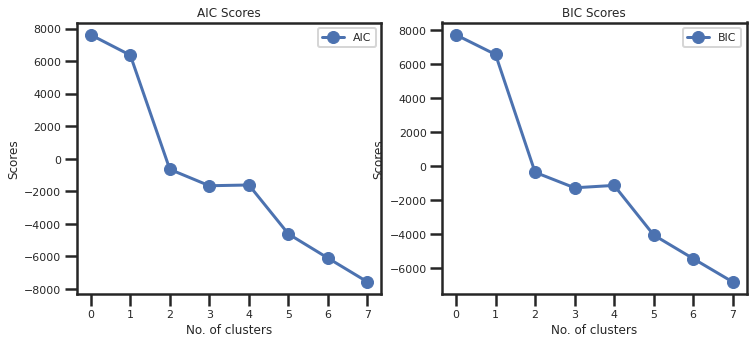

In [ ]:
sns.set_style("whitegrid")

sns.set(font_scale=0.5, style="ticks")
sns.set_context("poster", font_scale = .5, rc={"grid.linewidth": 0.6})


n_clusters=np.arange(0, 8);
fig, ax = plt.subplots(1, 2, figsize=(12,5));

plt.subplot(1, 2, 1);
plt.plot(n_clusters, aic,marker="o", label='AIC');
plt.title("AIC Scores");
plt.xticks(n_clusters);
plt.xlabel("No. of clusters");
plt.ylabel("Scores");
plt.legend();


plt.subplot(1, 2, 2);
plt.plot(n_clusters, bic, marker="o",label='BIC');
plt.title("BIC Scores");
plt.xticks(n_clusters);
plt.xlabel("No. of clusters");
plt.ylabel("Scores");
plt.legend();

plt.show();

In [ ]:
# inertia plotter function
def inertia_plot(clust, X, start = 2, stop = 20):
    inertia = []
    for i in range(start,stop):
        km = clust(n_clusters = i)
        labels = km.fit_predict(X)
        inertia.append(km.inertia_)
    plt.figure(figsize = (12,6))
    plt.plot(range(start,stop), inertia, marker = 'o')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.title('Inertia plot with K')
    plt.xticks(list(range(start, stop)))
    plt.show()

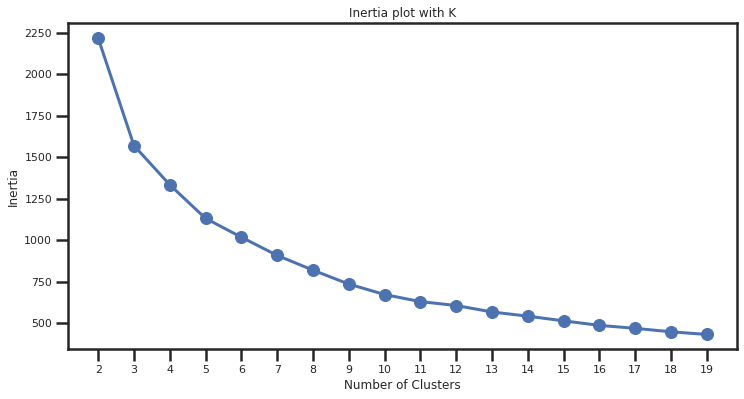

In [ ]:
from sklearn.cluster import KMeans
inertia_plot(KMeans, X_std)

In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score
# apply PCA and display clustering metrics
for y in range(2, 5):
    print("PCA with # of components: ", y)
    pca = sklearnPCA(n_components=y)
    data_p = pca.fit_transform(X_std)
    for i in range(2, 7):
        alg = KMeans(n_clusters = i, )
        label = alg.fit_predict(X_std)
        print('Silhouette-Score for', i,  'Clusters: ', silhouette_score(data_p, label) , '       Inertia: ',alg.inertia_)
    

PCA with # of components:  2
Silhouette-Score for 2 Clusters:  0.47409935344999443        Inertia:  2219.219815488008
Silhouette-Score for 3 Clusters:  0.4939576669214077        Inertia:  1570.8504615413594
Silhouette-Score for 4 Clusters:  0.2784503905692092        Inertia:  1334.1994853499068
Silhouette-Score for 5 Clusters:  0.2572474253062777        Inertia:  1131.698897151016
Silhouette-Score for 6 Clusters:  0.23382429659112025        Inertia:  1018.3774816986717
PCA with # of components:  3
Silhouette-Score for 2 Clusters:  0.3760955295659778        Inertia:  2219.219815488008
Silhouette-Score for 3 Clusters:  0.3689122132991225        Inertia:  1570.8340689024753
Silhouette-Score for 4 Clusters:  0.32835493335511795        Inertia:  1334.1994853499068
Silhouette-Score for 5 Clusters:  0.32572388376050976        Inertia:  1131.698897151016
Silhouette-Score for 6 Clusters:  0.3001189981414031        Inertia:  1021.8510183419713
PCA with # of components:  4
Silhouette-Score for 2 

Text(0, 0.5, 'PC2')

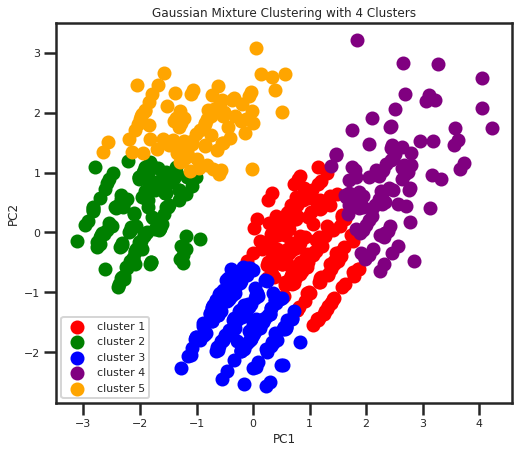

In [ ]:
data_p = pd.DataFrame(sklearnPCA(n_components = 2).fit_transform(X_std))
preds_gmm = pd.Series(GaussianMixture(n_components = 5).fit_predict(data_p))
data_p = pd.concat([data_p, preds_gmm], axis =1)
data_p.columns = [0,1,'target']
Gmm_trained = preds_gmm

fig = plt.figure(figsize = (18, 7))
colors = ['red', 'green', 'blue', 'purple', 'orange', 'brown']
plt.subplot(121)
plt.scatter(data_p[data_p['target']==0].iloc[:,0], data_p[data_p.target==0].iloc[:,1], c = colors[0], label = 'cluster 1')
plt.scatter(data_p[data_p['target']==1].iloc[:,0], data_p[data_p.target==1].iloc[:,1], c = colors[1], label = 'cluster 2')
plt.scatter(data_p[data_p['target']==2].iloc[:,0], data_p[data_p.target==2].iloc[:,1], c = colors[2], label = 'cluster 3')
plt.scatter(data_p[data_p['target']==3].iloc[:,0], data_p[data_p.target==3].iloc[:,1], c = colors[3], label = 'cluster 4')
plt.scatter(data_p[data_p['target']==4].iloc[:,0], data_p[data_p.target==4].iloc[:,1], c = colors[4], label = 'cluster 5')
plt.legend()
plt.title('Gaussian Mixture Clustering with 4 Clusters')
plt.xlabel('PC1')
plt.ylabel('PC2')

In [ ]:
data_p
#type(data_p)

,0,1,target
0,-1.380510,2.328908,4
1,-1.277844,1.819989,4
2,-1.071432,0.774228,1
3,-1.785011,1.107926,1
4,-0.025932,2.025922,4
...,...,...,...
677,2.399873,0.746358,3
678,-0.531967,-0.955200,2
679,0.436865,-0.304134,0
680,-0.419925,-1.635546,2


In [ ]:
loan_d.head()

,loan_id,account_id,date,amount,duration,payments,status,PCS_1,PCS_2
0,5314,1787,930705,96396,12,8033.0,2,-1.380510,2.328908
1,5316,1801,930711,165960,36,4610.0,1,-1.277844,1.819989
2,6863,9188,930728,127080,60,2118.0,1,-1.071432,0.774228
3,5325,1843,930803,105804,36,2939.0,1,-1.785011,1.107926
4,7240,11013,930906,274740,60,4579.0,1,-0.025932,2.025922


In [ ]:
loan_d["cluster"] = pd.DataFrame(data_p['target'])
loan_d.head()

,loan_id,account_id,date,amount,duration,payments,status,PCS_1,PCS_2,cluster
0,5314,1787,930705,96396,12,8033.0,2,-1.380510,2.328908,4
1,5316,1801,930711,165960,36,4610.0,1,-1.277844,1.819989,4
2,6863,9188,930728,127080,60,2118.0,1,-1.071432,0.774228,1
3,5325,1843,930803,105804,36,2939.0,1,-1.785011,1.107926,1
4,7240,11013,930906,274740,60,4579.0,1,-0.025932,2.025922,4


To find the features in PCS_1 and PCS_2 which contibutes max

In [ ]:
model = sklearnPCA(n_components=2).fit(X_std)
X_pc = model.transform(X_std)
# number of components
n_pcs= model.components_.shape[0]
print(n_pcs)
#print(model.components_)
#type(model)



2


In [ ]:
# get the index of the most important feature on EACH component
# LIST COMPREHENSION HERE
most_important = [np.abs(model.components_[i]).argmax() for i in range(n_pcs)]

print(most_important)

[1, 3]


Analysing the clusters

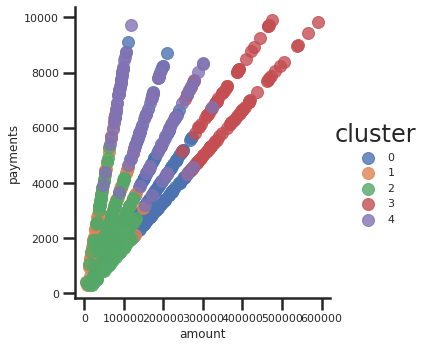

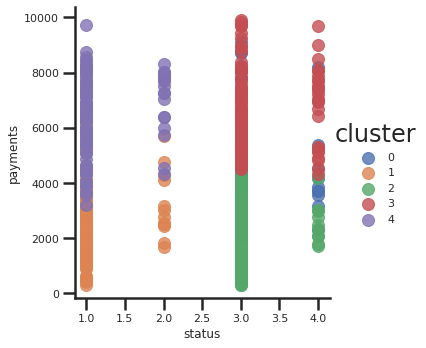

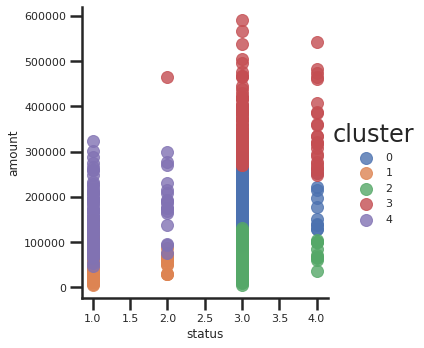

In [ ]:
sns.lmplot("amount","payments", data=loan_d, hue='cluster', fit_reg=False)
sns.lmplot("status","payments", data=loan_d, hue='cluster', fit_reg=False)
sns.lmplot("status","amount", data=loan_d, hue='cluster', fit_reg=False)
plt.show()

Calculating Latent Manifold Variable

Adding more information about the consumers transaction over time to the loan by filtering his transaction and calculating his median payment amount, last payment date, number of payents till date and balence as of that day.

In [ ]:
_tmpdf = trans_d.loc[trans_d['k_symbol'] == 'UVER']
#_tmpdf

unique_account_id = _tmpdf['account_id'].unique()
unique_account_id
account_idlist = list(unique_account_id)
account_idlist




In [100]:
#for getting all the parameters required to calculate the payment relaiability
balenceasoflastpaymentdate=[]
lastpaymentdate=[]
numberofPayments=[]
for acc_id in account_idlist:
  #print(acc_id)
  individual_acc_record = _tmpdf.loc[_tmpdf['account_id'] == acc_id]
  lastpaymentdate.append((individual_acc_record['date']).values[-1])
  
  balenceasoflastpaymentdate.append((individual_acc_record['balance'].values)[-1])
  
  numberofPayments.append(len(individual_acc_record['amount']))
  
  



individual_acc_record.head()

,trans_id,account_id,date,type,operation,amount,balance,k_symbol,bank,account
1044595,91156,309,981212,VYDAJ,PREVOD NA UCET,1901.0,39559.8,UVER,UV,74396675.0


In [ ]:
lastpaymtBal=[]
AccBal = []
lastpaymtDate=[]
noPayments=[]
pmt_relaibality=[]
for i in loan_d['account_id']:
    idx = account_idlist.index(i)
    #print(idx)
    AccBal.append(balenceasoflastpaymentdate[idx])
    noPayments.append(numberofPayments[idx])
    lastpaymtDate.append(lastpaymentdate[idx])
    ind_record = loan_d.loc[loan_d['account_id'] == i]
    balance_remaining = ind_record['amount'].values[0]-(ind_record['payments'].values[0]*numberofPayments[idx])
    print(balance_remaining)
    lastpaymtBal.append(balance_remaining) 
    
    if((ind_record['duration'].values[0]-numberofPayments[idx])>0):
        #loan_paid_so_far = numberofPayments[idx] * ind_record['payments'].values[0]
        balance_rem = ind_record['amount'].values[0]-(ind_record['payments'].values[0]*numberofPayments[idx])
        pmt_relaibality.append(((balenceasoflastpaymentdate[idx]/(ind_record['duration'].values[0]-numberofPayments[idx]))/ind_record['payments'].values[0]))
    else:
        pmt_relaibality.append(1)

ind_record.head()
print(len(lastpaymtBal))
print(lastpaymtBal)
print(len(loan_d))

In [102]:
loan_d['balenceAsOfLastpayment'] = lastpaymtBal
loan_d['lastPaymentDate'] = lastpaymtDate
loan_d['numberofpayments'] = noPayments
loan_d['account_balance'] = AccBal

# Payment Reliabality
loan_d['paymentReliability'] = pmt_relaibality

loan_d.head()

,loan_id,account_id,date,amount,duration,payments,status,balenceAsOfLastpayment,lastPaymentDate,numberofpayments,account_balance,paymentReliability
0,5314,1787,930705,96396,12,8033.0,2,64264.0,940612,4,35875.9,0.558258
1,5316,1801,930711,165960,36,4610.0,1,0.0,960612,36,34161.7,1.000000
2,6863,9188,930728,127080,60,2118.0,1,0.0,980712,60,22758.5,1.000000
3,5325,1843,930803,105804,36,2939.0,1,0.0,960712,36,49935.4,1.000000
4,7240,11013,930906,274740,60,4579.0,1,0.0,980812,60,37523.2,1.000000


In [103]:
loan_d.to_csv('data_new4.csv')

Applying Fractal KMeans
our Objective function is to get a good cluster where payment relaibilty is high

In [104]:
#scaling the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(loan_d[['status']])
loan_d['status'] = scaler.transform(loan_d[['status']])

scaler.fit(loan_d[['paymentReliability']])
loan_d['paymentReliability'] = scaler.transform(loan_d[['paymentReliability']])
loan_d.head()

,loan_id,account_id,date,amount,duration,payments,status,balenceAsOfLastpayment,lastPaymentDate,numberofpayments,account_balance,paymentReliability
0,5314,1787,930705,96396,12,8033.0,0.333333,64264.0,940612,4,35875.9,0.013337
1,5316,1801,930711,165960,36,4610.0,0.000000,0.0,960612,36,34161.7,0.020774
2,6863,9188,930728,127080,60,2118.0,0.000000,0.0,980712,60,22758.5,0.020774
3,5325,1843,930803,105804,36,2939.0,0.000000,0.0,960712,36,49935.4,0.020774
4,7240,11013,930906,274740,60,4579.0,0.000000,0.0,980812,60,37523.2,0.020774


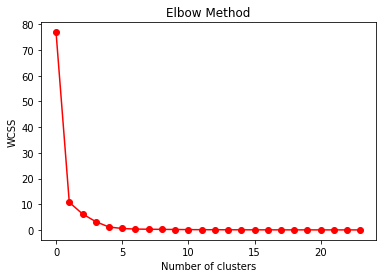

In [105]:
from sklearn.cluster import KMeans

wcss = []
for i in range(1, 25):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(loan_d[['status','paymentReliability']])
    wcss.append(kmeans.inertia_)
plt.plot( wcss, 'ro-', label="WCSS")
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [106]:
kmeans = KMeans(n_clusters=4, init="k-means++", n_init=10, max_iter=300) 
y_pred = kmeans.fit_predict(loan_d[['status','paymentReliability']])

loan_d["kcluster"] = 4 - y_pred
loan_d.head()
kmeans.cluster_centers_

array([[6.66666667e-01, 3.84728723e-02],
       [2.16493490e-15, 2.11247192e-02],
       [3.33333333e-01, 4.78521723e-02],
       [1.00000000e+00, 2.11174728e-02]])

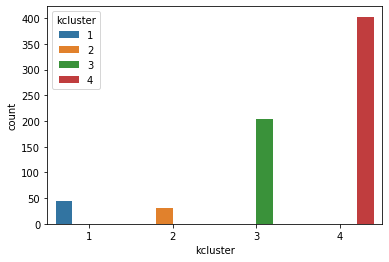

In [107]:
sns.countplot(x='kcluster',hue='kcluster',data=loan_d)

In [108]:
loan_d.head()

,loan_id,account_id,date,amount,duration,payments,status,balenceAsOfLastpayment,lastPaymentDate,numberofpayments,account_balance,paymentReliability,kcluster
0,5314,1787,930705,96396,12,8033.0,0.333333,64264.0,940612,4,35875.9,0.013337,2
1,5316,1801,930711,165960,36,4610.0,0.000000,0.0,960612,36,34161.7,0.020774,3
2,6863,9188,930728,127080,60,2118.0,0.000000,0.0,980712,60,22758.5,0.020774,3
3,5325,1843,930803,105804,36,2939.0,0.000000,0.0,960712,36,49935.4,0.020774,3
4,7240,11013,930906,274740,60,4579.0,0.000000,0.0,980812,60,37523.2,0.020774,3


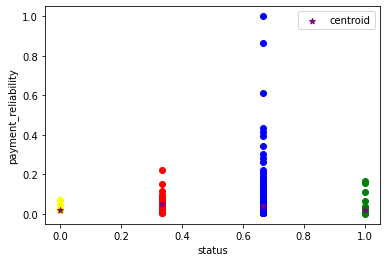

In [109]:
cl1 = loan_d[loan_d.kcluster == 1]
cl2 = loan_d[loan_d.kcluster == 2]
cl3 = loan_d[loan_d.kcluster == 3]
cl4 = loan_d[loan_d.kcluster == 4]
cl5 = loan_d[loan_d.kcluster == 5]
plt.scatter(cl1.status,cl1.paymentReliability,color='green')
plt.scatter(cl2.status,cl2.paymentReliability,color='red')
plt.scatter(cl3.status,cl3.paymentReliability,color='yellow')
plt.scatter(cl4.status,cl4.paymentReliability,color='blue')
plt.scatter(cl5.status,cl5.paymentReliability,color='orange')
plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],color='purple',marker='*',label='centroid')
plt.xlabel('status')
plt.ylabel('payment_reliability')
plt.legend()

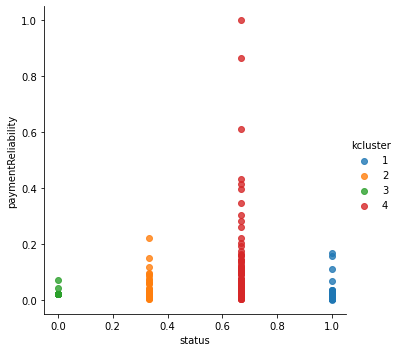

In [110]:
sns.lmplot("status","paymentReliability", data=loan_d, hue='kcluster', fit_reg=False)
plt.show()

In [111]:
from sklearn import metrics
print("Silhouette score for {} clusters k-means : {} ".format(4,metrics.silhouette_score(loan_d[['status','paymentReliability']],y_pred, metric='euclidean').round(3)))

Silhouette score for 4 clusters k-means : 0.912 


In [112]:
#Bigger cluster is 4.Applying Kmeans for the bigger cluster
fractal1_loan = loan_d.loc[loan_d['kcluster'] == 4]
fractal1_loan.head()

,loan_id,account_id,date,amount,duration,payments,status,balenceAsOfLastpayment,lastPaymentDate,numberofpayments,account_balance,paymentReliability,kcluster
23,5170,1071,940120,253200,60,4220.0,0.666667,4220.0,981212,59,27506.5,0.113685,4
30,6087,5313,940227,300660,60,5011.0,0.666667,10022.0,981212,58,29413.1,0.053352,4
38,7055,10079,940406,167100,60,2785.0,0.666667,8355.0,981212,57,22259.2,0.048795,4
39,6103,5385,940407,149340,60,2489.0,0.666667,7467.0,981212,57,44819.6,0.105001,4
42,6696,8321,940509,89040,60,1484.0,0.666667,5936.0,981212,56,60181.0,0.174640,4


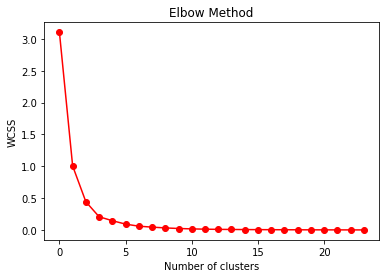

In [113]:
from sklearn.cluster import KMeans

wcss = []
for i in range(1, 25):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(fractal1_loan[['status','paymentReliability']])
    wcss.append(kmeans.inertia_)
plt.plot( wcss, 'ro-', label="WCSS")
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [114]:
kmeans = KMeans(n_clusters=5, init="k-means++", n_init=10, max_iter=300) 
y_pred = kmeans.fit_predict(fractal1_loan[['status','paymentReliability']])

fractal1_loan["kcluster"] = 5 - y_pred
loan_d.head()
kmeans.cluster_centers_

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


array([[0.66666667, 0.19180534],
       [0.66666667, 0.01643436],
       [0.66666667, 0.93236467],
       [0.66666667, 0.07685411],
       [0.66666667, 0.43988579]])

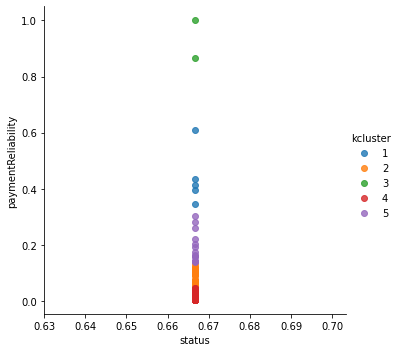

In [115]:
sns.lmplot("status","paymentReliability", data=fractal1_loan, hue='kcluster', fit_reg=False)
plt.show()

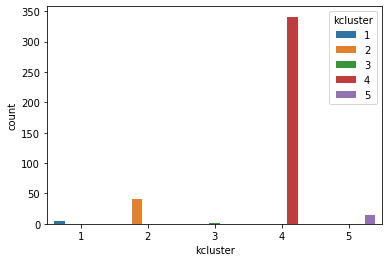

In [116]:
sns.countplot(x='kcluster',hue='kcluster',data=fractal1_loan)

In [117]:
print("Silhouette score for {} clusters k-means : {} ".format(5,metrics.silhouette_score(fractal1_loan[['status','paymentReliability']],y_pred, metric='euclidean').round(3)))

Silhouette score for 5 clusters k-means : 0.752 


In [118]:
#2nd Fractal cluster
fractal2_loan = fractal1_loan.loc[fractal1_loan['kcluster'] == 4]
fractal2_loan.head()


,loan_id,account_id,date,amount,duration,payments,status,balenceAsOfLastpayment,lastPaymentDate,numberofpayments,account_balance,paymentReliability,kcluster
45,5568,2933,940517,272520,60,4542.0,0.666667,22710.0,981212,55,30914.4,0.026857,4
61,6736,8558,940614,288360,60,4806.0,0.666667,28836.0,981212,54,27799.0,0.020169,4
63,5319,1811,940623,239460,60,3991.0,0.666667,23946.0,981212,54,43420.3,0.034468,4
65,5837,4260,940629,244560,60,4076.0,0.666667,24456.0,981212,54,54482.8,0.041447,4
114,5450,2345,941211,199680,60,3328.0,0.666667,36608.0,981212,49,20260.1,0.013255,4


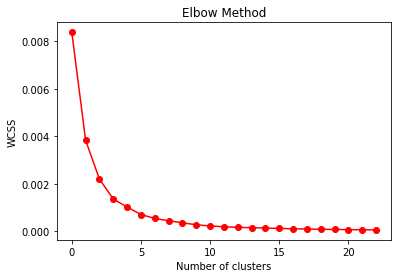

In [119]:
from sklearn.cluster import KMeans

wcss = []
for i in range(2, 25):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(fractal2_loan[['status','paymentReliability']])
    wcss.append(kmeans.inertia_)
plt.plot( wcss, 'ro-', label="WCSS")
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [120]:
kmeans = KMeans(n_clusters=4, init="k-means++", n_init=10, max_iter=300) 
y_pred = kmeans.fit_predict(fractal2_loan[['status','paymentReliability']])

fractal2_loan["kcluster"] = 4 - y_pred
loan_d.head()
kmeans.cluster_centers_

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


array([[0.66666667, 0.0268825 ],
       [0.66666667, 0.0091304 ],
       [0.66666667, 0.01730198],
       [0.66666667, 0.03766851]])

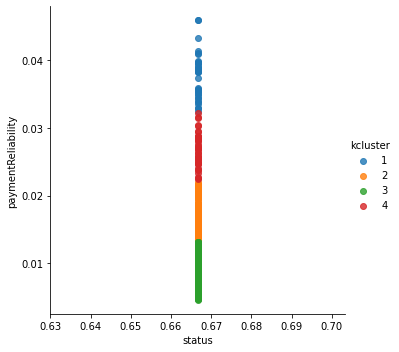

In [121]:
sns.lmplot("status","paymentReliability", data=fractal2_loan, hue='kcluster', fit_reg=False)
plt.show()

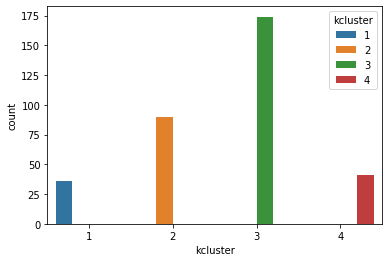

In [122]:
sns.countplot(x='kcluster',hue='kcluster',data=fractal2_loan)

In [123]:
print("Silhouette score for {} clusters k-means : {} ".format(4,metrics.silhouette_score(fractal2_loan[['status','paymentReliability']],y_pred, metric='euclidean').round(3)))

Silhouette score for 4 clusters k-means : 0.598 


In [124]:
#3rd Fractal cluster
fractal3_loan = fractal2_loan.loc[fractal2_loan['kcluster'] == 3]
fractal3_loan.head()

,loan_id,account_id,date,amount,duration,payments,status,balenceAsOfLastpayment,lastPaymentDate,numberofpayments,account_balance,paymentReliability,kcluster
137,5132,817,950217,538500,60,8975.0,0.666667,125650.0,981212,46,50323.6,0.010680,3
164,6704,8377,950601,417060,60,6951.0,0.666667,118167.0,981212,43,42612.5,0.010009,3
184,7227,10942,951002,314520,60,5242.0,0.666667,115324.0,981212,38,37494.1,0.009411,3
189,7304,11349,951029,419880,60,6998.0,0.666667,153956.0,981212,38,60530.9,0.010557,3
206,6545,7606,951212,191880,60,3198.0,0.666667,73554.0,981212,37,25456.7,0.009764,3


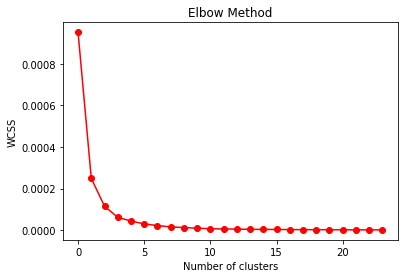

In [125]:
wcss = []
for i in range(1, 25):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(fractal3_loan[['status','paymentReliability']])
    wcss.append(kmeans.inertia_)
plt.plot( wcss, 'ro-', label="WCSS")
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [126]:
kmeans = KMeans(n_clusters=4, init="k-means++", n_init=10, max_iter=300) 
y_pred = kmeans.fit_predict(fractal3_loan[['status','paymentReliability']])

fractal3_loan["kcluster"] = 4 - y_pred
loan_d.head()
kmeans.cluster_centers_

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


array([[0.66666667, 0.01202967],
       [0.66666667, 0.00807737],
       [0.66666667, 0.01008342],
       [0.66666667, 0.00585309]])

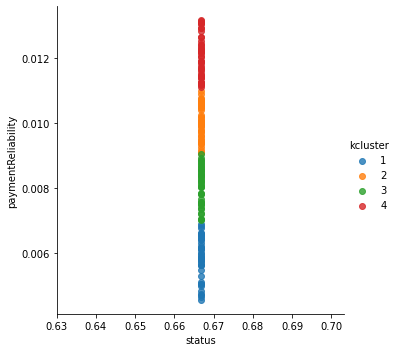

In [127]:
sns.lmplot("status","paymentReliability", data=fractal3_loan, hue='kcluster', fit_reg=False)
plt.show()

In [128]:
fractal3_loan.to_csv('data_new_fractal3.csv')

In [129]:
print("Silhouette score for {} clusters k-means : {} ".format(4,metrics.silhouette_score(fractal3_loan[['status','paymentReliability']],y_pred, metric='euclidean').round(3)))

Silhouette score for 4 clusters k-means : 0.581 


After applying Fractal clustering for 3 times , we can notice that from the scatter plot we are getting status C in which the contract is running with no problem and high payment reliabilty.These customers are low risk for us to give any promotional offers.

How does this improve the interpretability of your model?

**Cluster Interpretation**
As I have done the scaling on the data 0.6 to 0.8 range falls into status 3.

From the above scatter plot which represents the 3rd Fractral clustering - Which was recusrsively applied from the bigger cluster of initial dataframe loan_d

Cluster 1 : It depicts that the loan contract is still running and the payment relaibility is less still because of his account balance which is less.So this customer group can be considered as unpredictable(depends on his next account balance)

cluster 2:  It depicts that loan contract is still running and the customer in this group is paying a little extra what was expected (for example number of payments are more what was expected till last date).This group is considered to be on the safer group.

Cluster 4: It depicts that loan contract is still running and the customer in this group is paying more what was expected till date(more compared to cluster 4 group).Hence this group falls on very good payment reliability.

cluster 3: It depicts that loan contract is still running the customer in this group is paying on time.This group falls under a lower payment reliability.Payment reliability is better comapared to customers who falls in cluster1

How does it add value to your business case?

With latent manifold variable "Payment Reliability", our business use case that is to analyze the transaction behaviour and predict the loan risk will improve with payment relaibilty.It helps to see how customers are frequently paying the money what was expected to pay.So,it is the imprtant factor which can help us to decide the payment relaibility of a person and aid our business case whether the person falls into loan risk or not.
 